In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
min = df_train[['Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Hour','DHI','DNI','WS','RH','T']].max()

In [6]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [7]:
Day  = df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [8]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [9]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

In [51]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

In [13]:
epoch = 100

In [52]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 1ms/step - loss: 288.9031 - val_loss: 175.3714
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 167.2054 - val_loss: 157.4137
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 151.8488 - val_loss: 149.4633
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 152.9240 - val_loss: 147.5404
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 147.1542 - val_loss: 147.0453
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 148.7233 - val_loss: 150.9186
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 148.6483 - val_loss: 143.8951
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 140.5893 - val_loss: 150.6173
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 146.3554 - val_loss: 144.0072
Epoch 10/100
615/615 [==============================] -

136.88865661621094

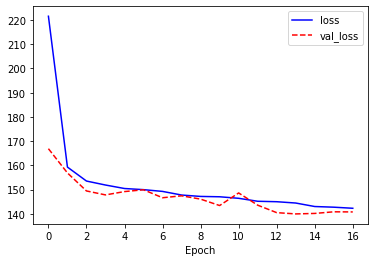

In [25]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [53]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4681 - val_loss: 1.6004
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4143 - val_loss: 1.6053
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4049 - val_loss: 1.6004
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3980 - val_loss: 1.5957
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4069 - val_loss: 1.6062
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4008 - val_loss: 1.6007
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4062 - val_loss: 1.6079
Epoch 00007: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.2845 - val_loss: 2.6155
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2590 - val_loss: 2.6059
Epoch 3/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 1s 1ms/step - loss: 2.7690 - val_loss: 3.2131
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7584 - val_loss: 3.1577
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.6596 - val_loss: 2.9887
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6307 - val_loss: 3.0048
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6354 - val_loss: 3.0164
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6357 - val_loss: 3.0659
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.3520 - val_loss: 2.6637
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3270 - val_loss: 2.6938
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3314 - val_loss: 2.6977
Epoch 4/100
820/820 [==========================

820/820 [==============================] - 1s 2ms/step - loss: 1.3803 - val_loss: 1.5624
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4100 - val_loss: 1.5634
Epoch 11/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3603 - val_loss: 1.5826
Epoch 12/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3830 - val_loss: 1.5755
Epoch 00012: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7764 - val_loss: 0.8627
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7749 - val_loss: 0.9403
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7780 - val_loss: 0.8891
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7742 - val_loss: 0.8783
Epoch 00004: early stopping


(3888, 18)

In [28]:
results[0], results[1]

(             0         0         0         0         0         0         0  \
 0    -0.007208 -0.007240  0.005783  0.016488  0.009341  0.004064  0.029597   
 1    -0.006766 -0.007369  0.005188  0.016327  0.009297  0.003761  0.029509   
 2    -0.005782 -0.005189  0.003775  0.016418  0.011415  0.006870  0.029207   
 3    -0.005958 -0.005104  0.003940  0.016418  0.011611  0.007090  0.029363   
 4    -0.008584 -0.002786  0.003562  0.016114  0.013767  0.010487  0.029069   
 ...        ...       ...       ...       ...       ...       ...       ...   
 3883 -0.014827  0.004310  0.000880  0.014228 -0.002549  0.013747  0.020386   
 3884 -0.014616  0.002194  0.000956  0.015063 -0.003505  0.014016  0.019748   
 3885 -0.015728  0.002448  0.001592  0.015489 -0.003203  0.014439  0.019969   
 3886 -0.015695  0.000360  0.011812  0.017918 -0.000447  0.019413  0.023538   
 3887 -0.017725  0.000719  0.010601  0.017597 -0.000041  0.019596  0.023822   
 
              0         0  
 0    -0.019634  0.012

In [17]:
from lightgbm import LGBMRegressor

In [32]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49215
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [54]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

In [59]:
res_0 = pd.concat([res_L0, res_D0], axis=1)
res_1 = pd.concat([res_L1, res_D1], axis=1)

In [68]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']] = 0

In [81]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)])/2
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)])/2

In [87]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
submission.to_csv('./submission/submission_20210118-1.csv', index=False)

In [89]:
results_1.sort_index()[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [88]:
results[0].sort_index()[:48]

,0,0,0,0,0,0,0,0,0
0,-0.054383,-0.077396,0.017636,0.001934,-0.017260,-0.023554,0.023951,0.034546,0.015895
1,-0.054989,-0.078058,0.017619,0.002192,-0.017288,-0.023530,0.023965,0.035055,0.015970
2,-0.056124,-0.076407,0.012608,0.001101,-0.017544,-0.025520,0.019945,0.026681,0.018218
3,-0.056871,-0.076160,0.012578,0.001377,-0.017368,-0.025321,0.019986,0.026664,0.017985
4,-0.054549,-0.075217,0.007305,-0.000571,-0.017373,-0.025870,0.015958,0.012309,0.015488
5,-0.054482,-0.075539,0.007546,-0.001123,-0.017683,-0.025759,0.015988,0.012422,0.015672
6,-0.052897,-0.071629,0.002485,-0.003630,-0.017824,-0.025654,0.013116,0.000668,0.012949
7,-0.050297,-0.071649,0.002458,-0.005247,-0.018835,-0.025467,0.013325,-0.001571,0.013606
8,-0.043220,-0.067566,0.006367,-0.009477,-0.019822,-0.025210,0.010773,-0.001386,0.013564
9,-0.046112,-0.067906,0.004724,-0.009587,-0.020418,-0.023944,0.010917,-0.000724,0.013921


In [90]:
(0.94+0.480766)/2

0.710383

In [93]:
(9.45 + 9.181172)/2

9.315586

In [92]:
df_test[:48]

,Hour,TARGET,DHI,DNI,WS,RH,T
288,0.000000,0.000000,0.000000,0.000000,0.066667,0.793529,0.300000
289,0.000000,0.000000,0.000000,0.000000,0.075000,0.800130,0.298148
290,0.043478,0.000000,0.000000,0.000000,0.083333,0.782599,0.296296
291,0.043478,0.000000,0.000000,0.000000,0.075000,0.782599,0.296296
292,0.086957,0.000000,0.000000,0.000000,0.075000,0.753273,0.296296
293,0.086957,0.000000,0.000000,0.000000,0.091667,0.765826,0.292593
294,0.130435,0.000000,0.000000,0.000000,0.100000,0.748728,0.288889
295,0.130435,0.000000,0.000000,0.000000,0.150000,0.761173,0.285185
296,0.173913,0.000000,0.000000,0.000000,0.200000,0.749919,0.281481
297,0.173913,0.000000,0.000000,0.000000,0.241667,0.768856,0.275926
